In [126]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [127]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False)

In [128]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 194...,29.883056,-97.941111,1949-10-10
1,lackland afb,tx,NaN,light,120.000000,1949 Lackland AFB&#44 TX. Lights racing acros...,29.384210,-98.581082,1949-10-10
2,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 En...,53.200000,-2.916667,1955-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960-10-10


In [129]:
# limita o df aos USA

df_us = df.loc[df['country'] == 'us']
df_us.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 194...,29.883056,-97.941111,1949-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960-10-10
5,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl wit...,36.595000,-82.188889,1961-10-10
7,norwalk,ct,us,disk,20.000000,A bright orange color changing to reddish colo...,41.117500,-73.408333,1965-10-10


In [130]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df_us[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

70290
[[ -97.9411111   29.8830556]
 [ -96.6458333   28.9783333]
 [-157.8036111   21.4180556]
 ...
 [ -97.4777778   35.6527778]
 [ -82.6958333   34.3769444]
 [ -80.1436111   26.1219444]]


In [131]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df_us['state'])
pesos = [states.count(s) for s in states]

In [132]:
scaler = MinMaxScaler()

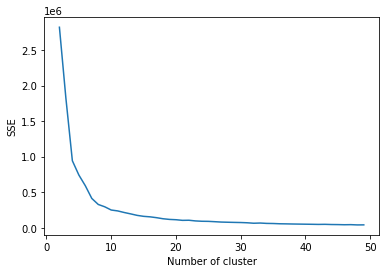

In [134]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### De acordo com o Elbow Criteria o número adequado de clusters é em torno de 20

In [ ]:
# aplica o coeficiente de silhouette

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon))
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

### De acordo com o Score Silhouette o número adequado de clusters é em torno de ????

In [15]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=20, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.71027257, 0.22622871],
       [0.72196002, 0.20905126],
       [0.17012595, 0.06550849],
       ...,
       [0.71445329, 0.3357752 ],
       [0.84783257, 0.31155167],
       [0.87086158, 0.1548186 ]])

In [18]:
centers = kmeans.cluster_centers_
centers

array([[0.51518883, 0.34542808],
       [0.84772906, 0.43254574],
       [0.84024079, 0.23247253],
       [0.49581215, 0.55404579],
       [0.63568916, 0.41355253],
       [0.87718479, 0.33407333],
       [0.17405701, 0.05880549],
       [0.77209247, 0.39443242],
       [0.24874659, 0.83319218],
       [0.91729518, 0.42597836],
       [0.86076977, 0.17647276],
       [0.71508855, 0.28731735],
       [0.79462413, 0.47215248],
       [0.58936401, 0.29409927],
       [0.92293489, 0.46909269],
       [0.49043043, 0.44023292],
       [0.72072319, 0.22238253],
       [0.82184151, 0.32117587],
       [0.49489956, 0.38113285],
       [0.53095956, 0.30077437]])

In [19]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

70290


array([16., 16.,  6., ..., 11., 17., 10.])

Text(0, 0.5, 'Longitude')

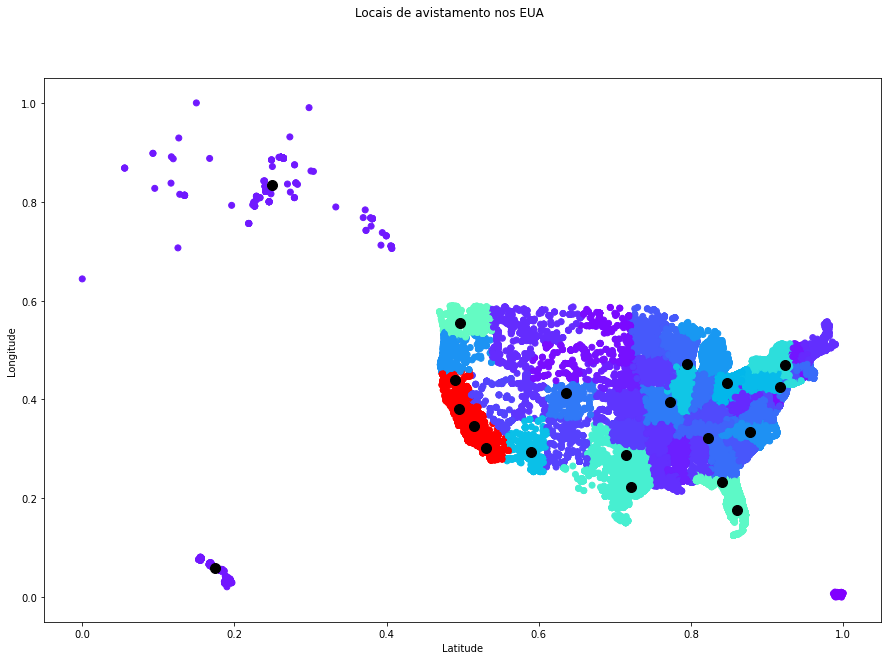

In [20]:
fig , ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento nos EUA')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [63]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

TypeError: __init__() got an unexpected keyword argument 'addressdetails'

In [23]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers_notscaled = pd.DataFrame(centers_notscaled, columns=['lon', 'lat'])
df_centers_notscaled

array([[-119.56153794,   36.16118668],
       [ -82.70730535,   40.74960135],
       [ -83.53720301,   30.21191234],
       [-121.70898497,   47.14890771],
       [-106.2069214 ,   39.74924478],
       [ -79.44283246,   35.56314143],
       [-157.36794584,   21.06501408],
       [ -91.0898349 ,   38.74220456],
       [-149.09036953,   61.85131567],
       [ -74.9975436 ,   40.40370313],
       [ -81.26205041,   27.26245108],
       [ -97.40737335,   33.10054313],
       [ -88.59273316,   42.8356555 ],
       [-111.34097009,   33.45774136],
       [ -74.37251406,   42.67449873],
       [-122.30542224,   41.15447892],
       [ -96.78290669,   29.68048019],
       [ -85.57632829,   34.88384326],
       [-121.81012461,   38.04172726],
       [-117.81372446,   33.80931335]])

In [25]:
centers_notscaled = df_centers[['lat', 'lon']]
centers_notscaled = centers_notscaled.to_records(index=False)
centers_notscaled = list(centers_notscaled)
centers_notscaled

[(36.16118668, -119.56153794),
 (40.74960135, -82.70730535),
 (30.21191234, -83.53720301),
 (47.14890771, -121.70898497),
 (39.74924478, -106.2069214),
 (35.56314143, -79.44283246),
 (21.06501408, -157.36794584),
 (38.74220456, -91.0898349),
 (61.85131567, -149.09036953),
 (40.40370313, -74.9975436),
 (27.26245108, -81.26205041),
 (33.10054313, -97.40737335),
 (42.8356555, -88.59273316),
 (33.45774136, -111.34097009),
 (42.67449873, -74.37251406),
 (41.15447892, -122.30542224),
 (29.68048019, -96.78290669),
 (34.88384326, -85.57632829),
 (38.04172726, -121.81012461),
 (33.80931335, -117.81372446)]

In [26]:
locations = [reverse(loc) for loc in centers_notscaled if loc]

In [125]:
df_locations = pd.DataFrame(locations)
df_locations.rename(columns={0:'Endereço', 1:'Latitude e Longitude'}, inplace=True)
df_locations

,Endereço,Latitude e Longitude
0,"6th Avenue, Kings County, California, 93212, U...","(36.16116210297419, -119.56487767846191)"
1,"Lime Road, Sandusky Township, Richland County,...","(40.74771451404237, -82.70729790537851)"
2,"Taylor County, Florida, United States","(30.0926733, -83.6377926)"
3,"Weyerhaeuser Mainline Rd, Greenwater, King Cou...","(47.14957555792047, -121.70901382647088)"
4,"Slate Creek Trail, Summit County, Colorado, Un...","(39.750193, -106.207856)"
5,"110, Carl Scott Road, Chatham County, North Ca...","(35.5610009, -79.4432619)"
6,United States,"(39.7837304, -100.4458825)"
7,"Alpine Woods Drive, Innsbrook, Warren County, ...","(38.7429755, -91.0895401)"
8,"Fishhook, Matanuska-Susitna, Alaska, United St...","(61.7557835, -149.2406783840539)"
9,"3117, River Road, Center Bridge, Solebury Town...","(40.404575384385424, -74.99745865616164)"
